# StarCat

Flip Tanedo  
Science Hack Day: SF 2017  
  
**Goal**: User inputs an image (perhaps of a cat). This notebook takes the image and identifies a set of stars that form a constellation for that image. 

In [30]:
import numpy as np
from matplotlib import pyplot as plt
from skimage import data
import skimage.io as io
from skimage.morphology import skeletonize
from skimage.util import invert
from skimage.color import *
from random import randint
import os

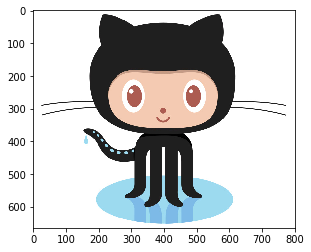

In [37]:
cat_image = io.imread('Octocat.jpg')
plt.imshow(cat_image)
plt.show()

In [ ]:
graycat

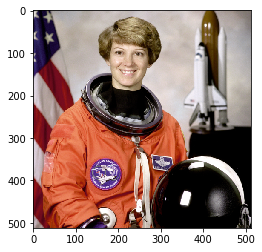

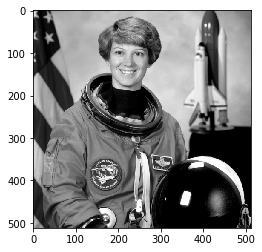

(512, 512)

In [51]:
from skimage.color import rgb2gray
from skimage import data
img = data.astronaut()
img_gray = rgb2grey(img)
plt.imshow(img)
plt.show()
plt.imshow(img_gray, cmap='gray')
plt.show()
img_gray.shape